# Training Pipeline

### Imports

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch import nn
from torch.optim import Adam
from torchvision.transforms import  Compose, ToTensor, Resize, RandomHorizontalFlip, RandomRotation, ColorJitter, RandomResizedCrop, Lambda
from PIL import Image
import matplotlib.pyplot as plt
from torchsummary import summary
import torchmetrics
from lightning.pytorch.loggers import WandbLogger
import wandb
from datetime import datetime
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
num_workers = 0

device = torch.device("cpu")


### MacOS

Set start method to fork and device to metal

In [3]:
import torch.multiprocessing as mp
mp.set_start_method("fork", force=True)  # Ensure fork is used on macOS

device = torch.device("cpu")

if torch.mps.is_available():
    #torch.mps.set_buffer_capacity(1)
    #torch.mps.set_reuse_buffers(True)
    #torch.mps.initialize()
    device = torch.device("mps")
    num_workers = 11

### Linux

In [5]:
print("CUDA verfügbar:", torch.cuda.is_available())
print("CUDA-Version:", torch.version.cuda)
print("GPU-Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Keine GPU gefunden")

if torch.cuda.is_available():
    device = torch.device("cuda")
    num_workers = 2


CUDA verfügbar: True
CUDA-Version: 12.4
GPU-Name: NVIDIA GeForce RTX 3070 Ti


## Load Datasets

In [3]:
# Dataset Path
DATASET_PATHS_TRAIN = ["../../Dataset/local_dataset_all/train"]
DATASET_PATHS_TEST = ["../../Dataset/local_dataset_all/test"]
DATASET_PATHS_VALID = ["../../Dataset/local_dataset_all/val"]
IMAGE_SIZE = (200, 200)
BATCH_SIZE = 64
SEED = 42

Set seed 

In [4]:
from lightning.pytorch import seed_everything

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
seed_everything(SEED)

Seed set to 42


42

## Custom augmentation

In [5]:
import sys
import os

# Den Pfad zum übergeordneten Ordner (helper-code) hinzufügen
sys.path.append(os.path.abspath(os.path.join('..', 'helper-code')))

# Jetzt kannst du das Modul RegressionModel aus Model_classes importieren
from Model_classes import ModularRegressionModel, TrainModelRegression
import training_helper_functions as hp


In [7]:

class ImagePriceDataset(Dataset):
    def __init__(self, dataset_paths, transform=None):
        self.files = []
        for dataset_path in dataset_paths:
            if not os.path.exists(dataset_path):
                raise ValueError(f"Path {dataset_path} doesn't exist.")
            for f in os.listdir(dataset_path):
                if f.endswith(".jpg"):
                    self.files.append((f, dataset_path))
        
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name, dataset_path = self.files[idx]
        image, label = hp.load_image_and_label_custom_dataset_regression(file_name, dataset_path, IMAGE_SIZE)


        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)
    
# Transformations for the Training Dataloader
transform_all = Compose([
    Lambda(lambda x: hp.custom_augmentation(x, [0,20])),
    RandomHorizontalFlip(p=0.5),      
    RandomRotation(degrees=180),       
    RandomResizedCrop(IMAGE_SIZE, scale=(0.9, 1.0)),
    ColorJitter(brightness=0.03,       
                contrast=0.1,          
                saturation=0.1,        
                hue=0.03),             
    ToTensor()                         
])

# Transformation for the Val and Test Dataloader
transform_test_train = Compose([
    ToTensor()                     
])

# Dataset
train_dataset = ImagePriceDataset(DATASET_PATHS_TRAIN, transform=transform_all)
test_dataset = ImagePriceDataset(DATASET_PATHS_TEST, transform=transform_test_train)
# Train-Valid Split
if len(DATASET_PATHS_VALID) > 0:
    val_dataset = ImagePriceDataset(DATASET_PATHS_VALID, transform=transform_test_train)
else:    
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)


## Test Augmentation

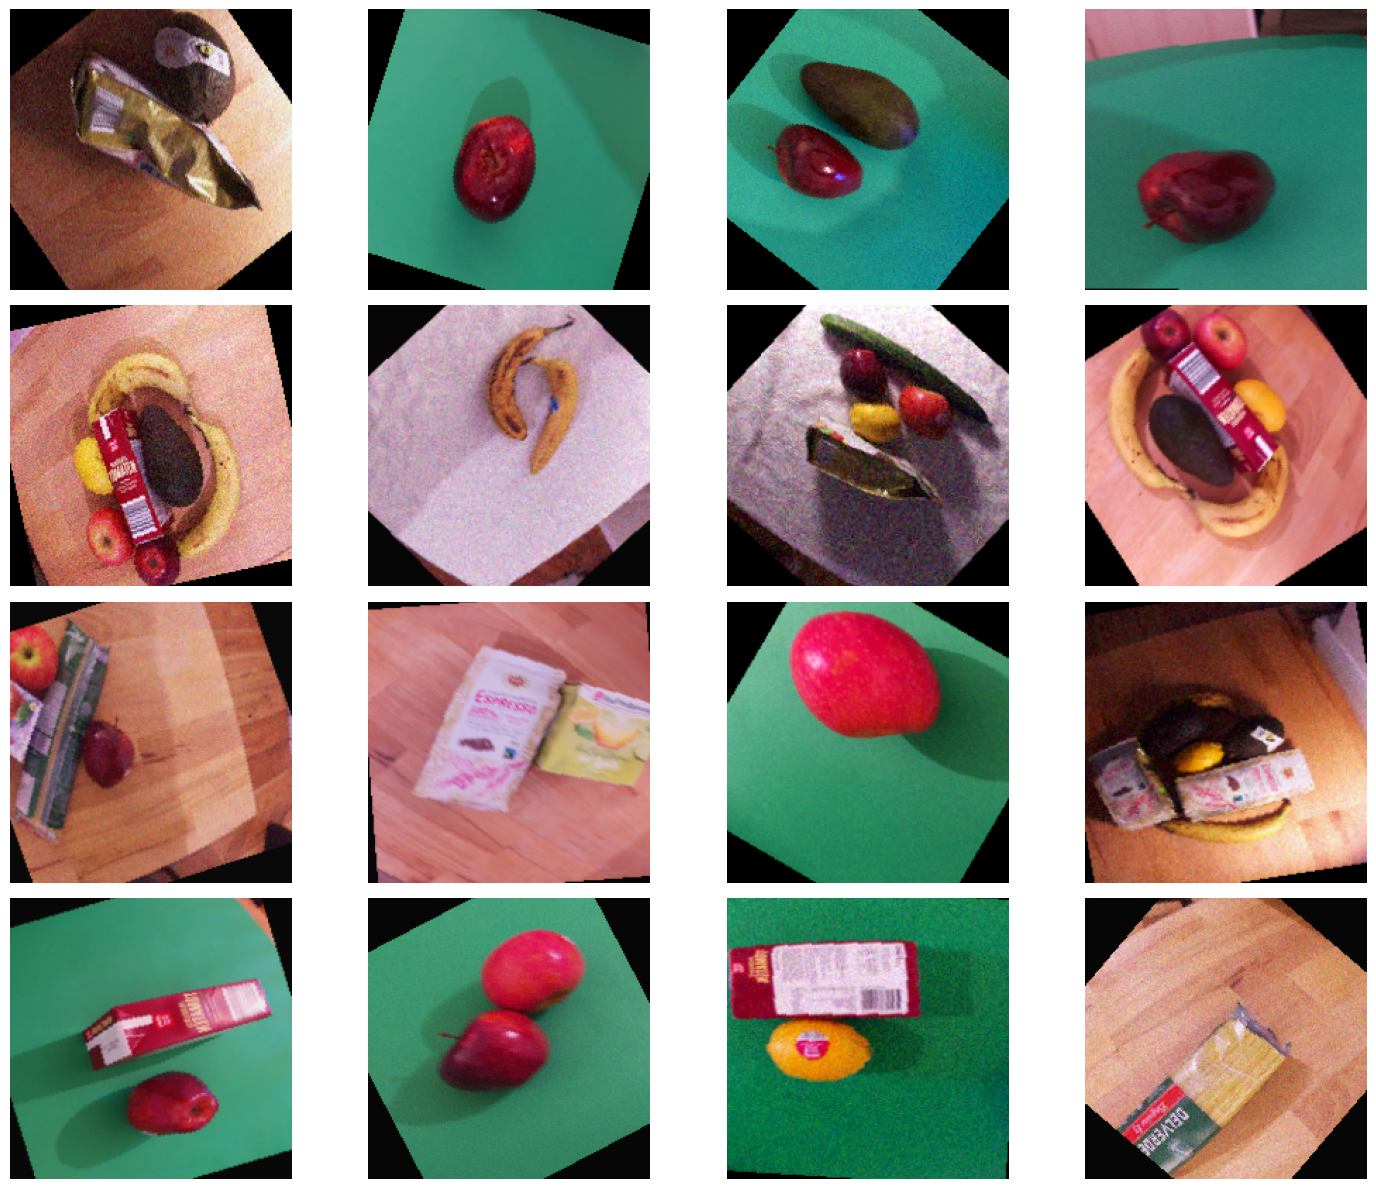

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Funktion zum Anzeigen von Bildern
def imshow(image, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    image = image.permute(1, 2, 0).numpy() 
    
    ax.imshow(image)
    ax.axis('off')

data_iter = iter(train_loader)
images, labels = next(data_iter)


fig, axes = plt.subplots(4, 4, figsize=(15, 12))  # 4 rows, 5 columns
axes = axes.flatten()  

for i in range(16):
    imshow(images[i], axes[i])  

plt.tight_layout() 
plt.show()


## Build Model

## Training

In [9]:
def show_predictions(model, test_dataset, num_samples=20):
    model.eval()  # Set the model to evaluation mode
    samples = random.sample(range(len(test_dataset)), num_samples)  # Randomly select samples
    
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))  # Create a 4x5 grid for the images
    
    for i, idx in enumerate(samples):
        image, label = test_dataset[idx]  # Load the image and label
        image_tensor = image.unsqueeze(0).to(model.device)  # Add batch dimension and move to GPU/CPU
        
        # Generate the prediction
        with torch.no_grad():
            prediction = model(image_tensor).cpu().item()
        
        # Display the image
        ax = axes[i // 5, i % 5]
        ax.imshow(image.permute(1, 2, 0))  # Convert tensor image to HWC format
        ax.set_title(f"Label: {label:.2f}\nPrediction: {prediction:.2f}")
        ax.axis("off")
    
    plt.tight_layout()

    try:
        wandb.log({"predictions": wandb.Image(plt)})  # Log predictions to wandb
    except Exception as e:
        print(f"Couldn't log predictions to wandb: {e}")

    plt.show()

def configure_wandb(additional_name="", tags=[]):
    # Sort the dataset names alphabetically
    dataset_names = "-".join(sorted([os.path.basename(path) for path in DATASET_PATHS_TRAIN]))
    group = "Regression-" + dataset_names
    name = dataset_names + additional_name + "_" + datetime.now().strftime("%d%b-%H:%M:%S")

    wandb_logger = WandbLogger(project="TinyML-CartDetection", group=group, name=name, tags=tags)
    wandb_logger.experiment.config.update({"batch_size": BATCH_SIZE, "image_size": IMAGE_SIZE, "seed": SEED})  # Log additional hyperparameters

    return wandb_logger


### Callbacks:

In [10]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',   # Track validation loss
    dirpath='checkpoints/',  # Directory to save checkpoints
    filename='best-checkpoint',  # Checkpoint file name
    save_top_k=1,  # Save only the best model (lowest val_loss)
    mode='min',  # We are minimizing validation loss
)

early_stopping = EarlyStopping(
    monitor="val_loss",  
    mode="min",      
    min_delta=0.1,
    patience=5,          
    verbose=True       
)

In [ ]:
model = ModularRegressionModel(num_filters= [64, 64, 64, 64, 64, 96, 96, 96], num_layers=8, kernel_size=3, learning_rate= 0.001).to("cpu") # So that it is mps compatible
summary(model, input_size=(3, 200, 200))
model.to(device)

try:
    trainer = pl.Trainer(max_epochs=100, logger=configure_wandb(), callbacks=[checkpoint_callback], fast_dev_run=False, accelerator=str(device), devices=1)

    trainer.fit(model, train_loader, val_loader) 

    # Load the best checkpoint (lowest validation loss)
    best_model_path = checkpoint_callback.best_model_path
    print(f"Best model saved at: {best_model_path}")

    # Load the best model for testing
    model = ModularRegressionModel.load_from_checkpoint(best_model_path)
    # Model Testing 
    trainer.test(model, test_loader)

    # Metrics and predictions
    # metrics = trainer.callback_metrics https://wandb.ai/authorize

    show_predictions(model, test_dataset)
except Exception as e:
    print(f"An error occurred: {e}")

finally:
    wandb.finish()


NameError: name 'RegressionModel' is not defined

### Architecture search

In [ ]:
NNs_grid_search_kernels = [[32, 32, 32, 32, 32, 32],[32, 32, 32, 16, 16, 8], [32, 64, 64, 64, 96, 96],[96, 96, 96, 96, 96, 96], [64, 64, 64, 64, 64, 64] ,[32, 64, 64, 64, 64, 64],[32, 32, 32, 32, 32, 32, 32], [32, 32, 32, 64, 64, 64, 64], [32, 32, 32, 64, 64, 64, 64, 64], [64, 64, 64, 64, 64, 96, 96, 96]]
NNs_grid_search_pooling_layers = [[[1,2,3],[4]], [[1,2,3],[4]], [[1,2,3],[4]], [[1,2,3],[4]], [[1,2,3],[4]], [[1,2,3],[4]], [[1,2,4],[5]], [[2,3,4],[5]], [[2,3,5],[6]], [[2,3,5],[6]]]  

for i in range(5,10):

    dataset_names = "-".join(sorted([os.path.basename(path) for path in DATASET_PATHS]))
    group = "Regression-"+dataset_names
    name = dataset_names+"_"+datetime.now().strftime("%d%b-%H:%M:%S")
    wandb_logger = WandbLogger(project="TinyML-CartDetection", group=group, name=name, tags=["GridSearch1"])
    wandb_logger.experiment.config.update({"batch_size": BATCH_SIZE, "image_size": IMAGE_SIZE, "seed": SEED})
    checkpoint_callback.filename = name
    try:
        trainer = pl.Trainer(max_epochs=100, logger=wandb_logger, callbacks=[checkpoint_callback, early_stopping], fast_dev_run=False, accelerator=str(device), devices=1)

        model = RegressionModel(num_filters=NNs_grid_search_kernels[i], num_layers=len(NNs_grid_search_kernels[i]), kernel_size=3, learning_rate= 0.0015).to(device)

        #summary(model, input_size=(3, 200, 200))

        trainer.fit(model, train_loader, val_loader) 

        # Load the best checkpoint (lowest validation loss)
        best_model_path = checkpoint_callback.best_model_path

        # Load the best model for testing
        model = RegressionModel.load_from_checkpoint(best_model_path)
        trainer.test(model, test_loader)

        # Metrics and predictions
        #metrics = trainer.callback_metrics
        show_predictions(model, test_dataset)

    except Exception as e:
        print(f"An error occurred: {e}")

    finally:
        wandb.finish()    

## Finetuning

Helper functions for finetuning and testing

In [ ]:
def finetune(ckpt, model_class, lr=1e-4, freeze_backbone=True, name_additions="", tags=[]):
    # Define different learning rates for backbone and head
    '''optimizer = torch.optim.Adam([
        {'params': model.features.parameters(), 'lr': 1e-4},  # Backbone
        {'params': model.classifier.parameters(), 'lr': 1e-3}  # Regression head
    ])'''

    model = model_class.load_from_checkpoint(ckpt)

    summary(model.to('cpu'), input_size=(3, IMAGE_SIZE[0], IMAGE_SIZE[1]))

    wandb_logger = configure_wandb(additional_name=name_additions+"-FT", tags=["Finetuning"]+tags)

    if freeze_backbone:
        model.freeze_backbone()

    def configure_optimizers(model):
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        return optimizer

    # For now just change LR globally
    model.learning_rate = lr
    #model.configure_optimizers = configure_optimizers.__get__(model, model_class)    

    try:
        trainer = pl.Trainer(max_epochs=100, logger=wandb_logger, callbacks=[checkpoint_callback, early_stopping], fast_dev_run=False, accelerator=str(device), devices=1)

        trainer.fit(model, train_loader, val_loader) 

        # Load the best model for testing
        trainer.test(model, test_loader, ckpt_path=checkpoint_callback.best_model_path)

        show_predictions(model, test_dataset)
    except Exception as e:
        print(f"An error occurred: {e}")

    finally:
        wandb.finish()


def test_only(ckpt, model_class):
    model = model_class.load_from_checkpoint(ckpt)  # model=getEfficientnetRegression()
    trainer = pl.Trainer(accelerator=str(device), devices=1)
    trainer.test(model, test_loader, ckpt_path=ckpt)
    show_predictions(model, test_dataset)        

In [ ]:
#finetune("checkpoints/MIT_local_data_11Jan-15:21:16.ckpt", RegressionModel, name_additions="T5", freeze_backbone=True)
finetune("checkpoints/MIT_local_data_11Jan-18:09:20.ckpt", RegressionModel, lr=1e-3, name_additions="T10", freeze_backbone=False, tags=["full"])

## Using prominent architectures

### Efficientnet

We use EfficientnetV1-B0 as all other models have even more params and this one has ~5M params. 

In [25]:
from torchvision.models import efficientnet_b0

def getEfficientnetRegression():
    # Load EfficientNet-B0 with pretrained weights
    model = efficientnet_b0(weights="IMAGENET1K_V1")
    print(model)

    # Replace head
    output = model.features[-1][0].out_channels  # Output channels of the last block

    # Define custom regression head
    regression_head = nn.Sequential(
        nn.Linear(output, 100),  # Adjust input size as needed
        nn.ReLU(),
        nn.Linear(100, 50),
        nn.ReLU(),
        nn.Linear(50, 1)
    )

    # Replace the classifier with your regression head
    model.classifier = regression_head
    return model

#### Training

In [27]:
model = TrainModelRegression(getEfficientnetRegression())
summary(model, input_size=(3, IMAGE_SIZE[0], IMAGE_SIZE[1]))

wandb_logger = configure_wandb(additional_name="_Efficientnet", tags=["Efficientnet","Imagenet"])

try:
    trainer = pl.Trainer(max_epochs=100, logger=wandb_logger, callbacks=[checkpoint_callback, early_stopping], fast_dev_run=False, accelerator=str(device), devices=1)

    trainer.fit(model, train_loader, val_loader) 

    # Load the best model for testing
    trainer.test(model, test_loader, ckpt_path=checkpoint_callback.best_model_path)

    show_predictions(model, test_dataset)
except Exception as e:
    print(f"An error occurred: {e}")

finally:
    wandb.finish()


NameError: name 'TrainModelRegression' is not defined

#### LR-Finder

WIP not tested yet

In [ ]:
from pytorch_lightning.tuner import Tuner

# Initialize your LightningModule
model = RegressionModel()

# Use the learning rate finder
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(model, train_dataloader)

# Plot the learning rate curve
fig = lr_finder.plot(suggest=True)
suggested_lr = lr_finder.suggestion()

print(f"Suggested Learning Rate: {suggested_lr}")

#### Finetuning (train on custom, test on test)

In [ ]:
# Define different learning rates for backbone and head
'''optimizer = torch.optim.Adam([
    {'params': model.features.parameters(), 'lr': 1e-4},  # Backbone
    {'params': model.classifier.parameters(), 'lr': 1e-3}  # Regression head
])'''

model = TrainModelRegression(getEfficientnetRegression())
# Load the checkpoint
checkpoint = torch.load("checkpoints/MIT_local_data_Efficientnet_12Jan-15:27:54.ckpt")

# Clean the state_dict by removing unnecessary prefixes
new_state_dict = {}
for key, value in checkpoint['state_dict'].items():
    new_key = key.replace('model.model.', '')  # remove the unwanted prefix
    new_state_dict[new_key] = value

# Load the modified state_dict into your model
model.load_state_dict(new_state_dict)


summary(model, input_size=(3, 200, 200))

wandb_logger = configure_wandb(additional_name="_Efficientnet", tags=["Efficientnet","MIT-Pretrain"])


try:
    trainer = pl.Trainer(max_epochs=100, logger=wandb_logger, callbacks=[checkpoint_callback, early_stopping], fast_dev_run=False, accelerator=str(device), devices=1)

    trainer.fit(model, train_loader, val_loader) 

    # Load the best model for testing WHY NOT LOADED HERE?
    trainer.test(model, test_loader)#, ckpt_path=checkpoint_callback.best_model_path)

    show_predictions(model, test_dataset)
except Exception as e:
    print(f"An error occurred: {e}")

finally:
    wandb.finish()